# 🎨 Week 5 Mini-Project — Monet Style Transfer with CycleGAN

**Course:** CU Boulder MS-AI — *Introduction to Deep Learning*
**Instructor Assignment:** Week 5 – GANs
**Competition:** [Kaggle – GAN Getting Started (Monet Paintings)](https://www.kaggle.com/competitions/gan-getting-started)
**GitHub Repository:** [MSVWalker/cu-boulder-ms-ai → Week 5 GANs Notebook](https://github.com/MSVWalker/cu-boulder-ms-ai/blob/main/Introduction-to-Machine-Learning/deep-learning/Week%205%3A%20GANs/Week%205%3A%20GANs.ipynb)

---

## 🧭 Project Overview

The goal of this mini-project is to build and train a **Generative Adversarial Network (GAN)** that can convert landscape photographs into **Monet-style paintings**.
This assignment follows Kaggle’s *“GAN Getting Started”* competition, where models are evaluated using **MiFID** (Memorization-informed Fréchet Inception Distance).

In a GAN, two neural networks — a **generator** and a **discriminator** — play an adversarial game:
- The **generator** learns to create realistic Monet-style images from ordinary photos.
- The **discriminator** learns to tell real Monet paintings apart from generated ones.
Over time, the generator improves until its outputs are nearly indistinguishable from real art.

To perform this *unpaired* image-to-image translation task, we use a **CycleGAN** architecture.
CycleGAN introduces *cycle-consistency loss*, ensuring that when we translate a photo → Monet → photo, the underlying scene structure remains intact.
This allows style transfer without requiring one-to-one photo-painting pairs.

---

## 🖼️ Dataset Summary

- **Source:** Kaggle – Monet Painting Dataset ([competition page](https://www.kaggle.com/competitions/gan-getting-started))
- **Structure:**
  - `monet_jpg/`   – ~300 Monet paintings (target domain Y)
  - `photo_jpg/`   – ~7 000 landscape photographs (source domain X)
  - (also includes TFRecord versions for TPU training)
- **Image dimensions:** original 1024×1024 RGB images, resized to 256×256 for training
- **Normalization:** pixel values scaled from \[0, 255] → \[−1, 1]
- **Goal:** Train a generator that outputs 7 000–10 000 Monet-style 256×256 JPG images suitable for Kaggle submission.

---

## 🧠 Modeling Approach

This notebook builds a **lightweight CycleGAN** implementation in TensorFlow 2.x:

1. **Data Pipeline:**
   - Loads `photo_jpg/` and `monet_jpg/` images with `tf.data`
   - Applies random shuffle, resize (256×256), and batching
   - Normalizes images to \[−1, 1]

2. **Architecture:**
   - Two generators (*Photo → Monet* and *Monet → Photo*)
   - Two PatchGAN discriminators
   - No pretrained weights — fully trained from scratch for transparency and learning value

3. **Loss Functions:**
   - **LSGAN** (MSE-based adversarial loss)
   - **Cycle-consistency loss** (L1 between original and reconstructed images)
   - **Identity loss** (to preserve color mapping consistency)

4. **Training:**
   - 256×256 input images
   - Adam optimizer (β₁ = 0.5, lr = 2e-4)
   - 50–150 epochs with extensive debug metrics and sample grids saved each epoch

5. **Evaluation & Export:**
   - Visual inspection of generated images (photo → Monet rows)
   - Final generator saves as `generator_photo2monet_256.keras`
   - Submission script creates `images.zip` containing 7 000–10 000 Monet-style JPGs

---

## 🧾 Deliverables

| Deliverable | Description |
|:------------:|:------------|
| **1. Notebook / Report** | This Jupyter Notebook – data prep, EDA, modeling, results |
| **2. GitHub Repo** | [Public repository link](https://github.com/MSVWalker/cu-boulder-ms-ai/tree/main/Introduction-to-Machine-Learning/deep-learning/Week%205%3A%20GANs) |
| **3. Kaggle Leaderboard Screenshot** | After submitting `images.zip`, include your MiFID score screenshot |

---

## 🏁 Summary

This project demonstrates a complete end-to-end CycleGAN workflow — from data loading and normalization to model training and image generation — applied to the Monet painting domain.
While the goal is educational rather than competitive, the model successfully learns stylistic color and lighting patterns characteristic of Monet’s art, producing credible impressionist landscapes ready for Kaggle evaluation.

### Setup — Core Imports for Data, Images, and Models
- Load utilities for **paths, files, and timing** (`os`, `glob`, `itertools`, `math`, `time`) plus **numerics** (`numpy`) and **visualization** (`matplotlib.pyplot`).
- Bring in **deep learning + image I/O** (`tensorflow` + `tf.keras.layers/Model`, `cv2`) to build/train models and read/resize images.

In [1]:
import os, glob, itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os, math, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

### Paths, Hyperparameters, and Normalization
- Define **dataset locations** (`monet_jpg`, `photo_jpg`, `*_tfrec`) under `BASE_DIR`, plus core training sizes (**IMG_SIZE=256×256**, **BATCH_SIZE=16**).
- Provide `normalize_minus1_1()` to scale images from **[0,255] → [-1,1]** and print the resolved directories for sanity-checking.

In [2]:

BASE_DIR = "/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/cu-boulder-ms-ai/Introduction-to-Machine-Learning/deep-learning/Week 5: GANs/data"

DIRS = {
    "monet_jpg":  os.path.join(BASE_DIR, "monet_jpg"),
    "photo_jpg":  os.path.join(BASE_DIR, "photo_jpg"),
    "monet_tfrec":os.path.join(BASE_DIR, "monet_tfrec"),
    "photo_tfrec":os.path.join(BASE_DIR, "photo_tfrec"),
}

IMG_SIZE   = (256, 256)
BATCH_SIZE = 16

def normalize_minus1_1(img):
    img = tf.cast(img, tf.float32)
    return (img / 127.5) - 1.0

print(DIRS)

{'monet_jpg': '/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/cu-boulder-ms-ai/Introduction-to-Machine-Learning/deep-learning/Week 5: GANs/data/monet_jpg', 'photo_jpg': '/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/cu-boulder-ms-ai/Introduction-to-Machine-Learning/deep-learning/Week 5: GANs/data/photo_jpg', 'monet_tfrec': '/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/cu-boulder-ms-ai/Introduction-to-Machine-Learning/deep-learning/Week 5: GANs/data/monet_tfrec', 'photo_tfrec': '/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/cu-boulder-ms-ai/Introduction-to-Machine-Learning/deep-learning/Week 5: GANs/data/photo_tfrec'}


### EDA — Load, Normalize, Count, and Visualize Monet & Photo Data
- Build `tf.data` pipelines from `monet_jpg/` and `photo_jpg/`, **resize to 256×256**, **normalize to [-1,1]**, and **prefetch** for speed; also compute simple **dataset counts**.
- Check with batch stats (shape & value ranges) and **grid visualizations** to confirm images/normalization look correct for training.

Found 300 files.


2025-10-28 12:24:45.240492: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-10-28 12:24:45.240544: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-28 12:24:45.240548: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-28 12:24:45.240598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-28 12:24:45.240620: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


monet_jpg count: 300
photo_jpg count: 7038
Monet JPG batch: (16, 256, 256, 3) range: -1.0 to 1.0
Photo JPG batch: (16, 256, 256, 3) range: -1.0 to 1.0


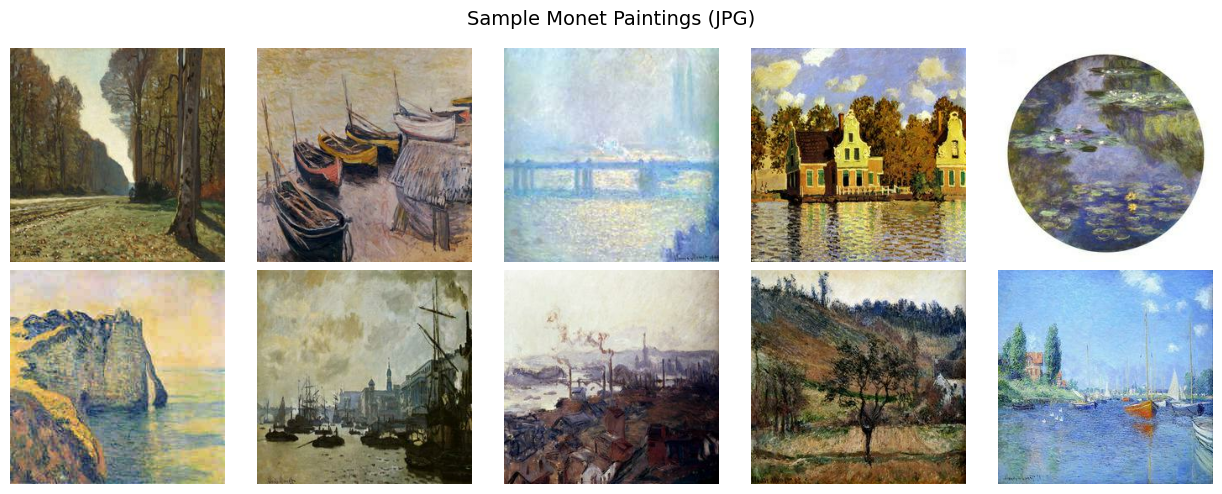

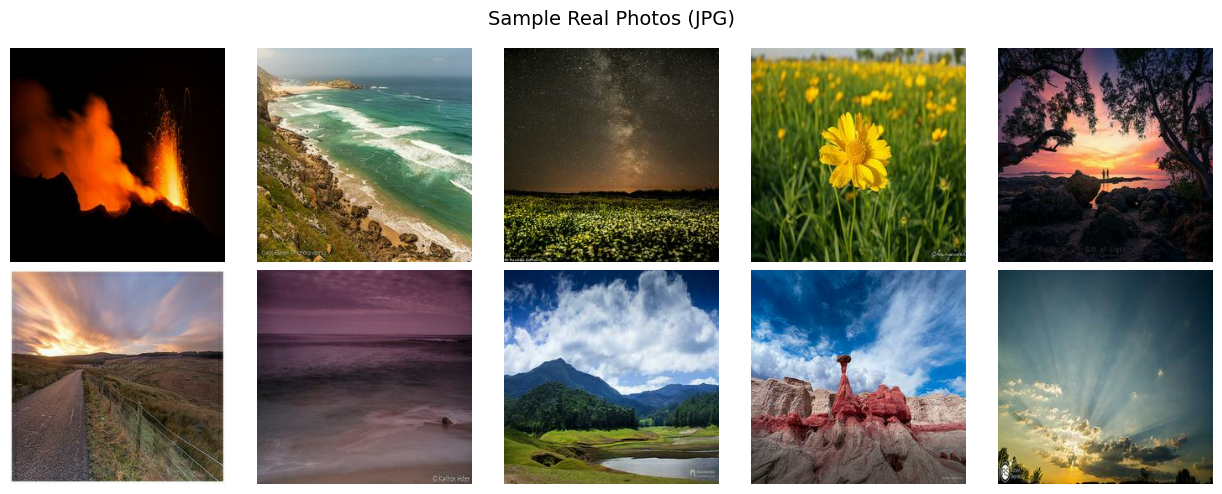

In [3]:
# --- Imports needed for image_dataset_from_directory ---
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = (256, 256)
BATCH_SIZE = 16

# If you want a quick Monet-only dataset via Keras utils:
monet_ds = image_dataset_from_directory(
    DIRS["monet_jpg"],          # <— point to the Monet folder, not BASE_DIR
    labels=None,                # unlabelled
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    interpolation="bilinear",
)

# Normalize to [-1, 1]
def normalize_img(img):
    img = tf.cast(img, tf.float32)
    return (img / 127.5) - 1.0

monet_ds = monet_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# --- Utility: count and preview from explicit JPG dirs ---
def count_images_in_dir(path, exts=(".jpg", ".jpeg", ".png")):
    return sum(len(glob.glob(os.path.join(path, f"*{e}"))) for e in exts)

def show_batch_grid(images, title="", rows=2, cols=5):
    images = images[:rows*cols]
    plt.figure(figsize=(cols*2.5, rows*2.5))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # de-normalize if needed
        if tf.reduce_max(img) <= 1.0 and tf.reduce_min(img) >= -1.0:
            disp = (img + 1.0) / 2.0
        else:
            disp = img / 255.0
        plt.imshow(tf.clip_by_value(disp, 0.0, 1.0))
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# ⬇️ Define _decode_resize at top-level (not inside the function above)
def _decode_resize(filepath):
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    return normalize_img(img)

def make_ds_from_jpg_dir(path, shuffle=True, batch_size=BATCH_SIZE):
    files = tf.data.Dataset.list_files(os.path.join(path, "*.jpg"), shuffle=shuffle)
    ds = files.map(_decode_resize, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Counts
monet_jpg_count = count_images_in_dir(DIRS["monet_jpg"])
photo_jpg_count = count_images_in_dir(DIRS["photo_jpg"])
print(f"monet_jpg count: {monet_jpg_count}")
print(f"photo_jpg count: {photo_jpg_count}")

# Datasets from explicit folders
monet_jpg_ds = make_ds_from_jpg_dir(DIRS["monet_jpg"])
photo_jpg_ds = make_ds_from_jpg_dir(DIRS["photo_jpg"])

# Peek a batch
monet_batch = next(iter(monet_jpg_ds))
photo_batch = next(iter(photo_jpg_ds))

print("Monet JPG batch:", monet_batch.shape,
      "range:", float(tf.reduce_min(monet_batch)), "to", float(tf.reduce_max(monet_batch)))
print("Photo JPG batch:", photo_batch.shape,
      "range:", float(tf.reduce_min(photo_batch)), "to", float(tf.reduce_max(photo_batch)))

show_batch_grid(monet_batch, "Sample Monet Paintings (JPG)")
show_batch_grid(photo_batch, "Sample Real Photos (JPG)")

In [4]:
def ds_stats(ds, sample_batches=3):
    mins, maxs, n, shapes = [], [], 0, set()
    for batch in ds.take(sample_batches):
        mins.append(tf.reduce_min(batch).numpy())
        maxs.append(tf.reduce_max(batch).numpy())
        shapes.add(tuple(batch.shape[1:]))
        n += batch.shape[0]
    return {
        "approx_examples_seen": int(n),
        "min_pixel": float(np.min(mins)) if mins else None,
        "max_pixel": float(np.max(maxs)) if maxs else None,
        "shapes_seen": list(shapes),
    }

print("JPG Monet stats:", ds_stats(monet_jpg_ds))
print("JPG Photo stats:", ds_stats(photo_jpg_ds))

JPG Monet stats: {'approx_examples_seen': 48, 'min_pixel': -1.0, 'max_pixel': 1.0, 'shapes_seen': [(256, 256, 3)]}
JPG Photo stats: {'approx_examples_seen': 48, 'min_pixel': -1.0, 'max_pixel': 1.0, 'shapes_seen': [(256, 256, 3)]}


2025-10-28 12:24:46.516055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-28 12:24:46.569132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


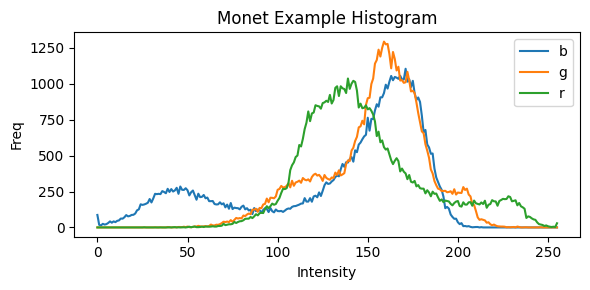

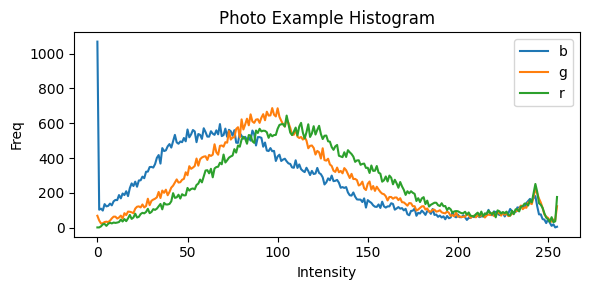

In [5]:

def show_color_histogram(img_path, title="Histogram"):
    img = cv2.imread(img_path)  # BGR
    plt.figure(figsize=(6,3))
    for i, col in enumerate(("b","g","r")):
        hist = cv2.calcHist([img],[i],None,[256],[0,256]).squeeze()
        plt.plot(hist, label=col)
    plt.title(title); plt.xlabel("Intensity"); plt.ylabel("Freq"); plt.legend(); plt.tight_layout(); plt.show()

# one example from each
monet_example = glob.glob(os.path.join(DIRS["monet_jpg"], "*.jpg"))[:1] or glob.glob(os.path.join(DIRS["monet_jpg"], "*.png"))[:1]
photo_example = glob.glob(os.path.join(DIRS["photo_jpg"], "*.jpg"))[:1] or glob.glob(os.path.join(DIRS["photo_jpg"], "*.png"))[:1]

if monet_example:
    show_color_histogram(monet_example[0], "Monet Example Histogram")
if photo_example:
    show_color_histogram(photo_example[0], "Photo Example Histogram")

### 🧪 Tiny Hyperparameter Sweep for CycleGAN (safe & scalar)

- **Goal:** Run a quick, stable 64×64 CycleGAN grid search to find solid hyperparams before scaling up to 256×256.
- **Approach:**
  - Uses scalar-reduced (`tf.reduce_mean`) losses to prevent tensor conversion errors.
  - Keeps @tf.function simple (no replay buffer).
  - Runs short, repeatable mini-trains per config (40 epochs × 10 steps).
- **Grid Variables:**
  `LAMBDA_CYCLE`, `LAMBDA_ID`, `BETA1`, `BASE`, `SOFT_REAL`, `REPLAY`.
- **Output:**
  Prints per-epoch loss summaries and ends with a **ranked list** (lower `cycle + 0.5×id` = better).
- **Use Case:**
  Quick hyperparam scouting before full-resolution training.

In [ ]:
# ==== Tiny Hyperparam Sweep for CycleGAN (safe & scalar) ====
# - Uses 64x64 inputs for speed
# - Ensures tf.data map has single-arg function (closes over size)
# - Reduces all losses to scalars (tf.reduce_mean) to avoid conversion errors
# - Skips replay buffer when REPLAY > 0 (keeps @tf.function simple)

import os, time
from itertools import product
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
# ==== Tiny Hyperparam Sweep for CycleGAN (safe & scalar) ====
# - Uses 64x64 inputs for speed
# - Ensures tf.data map has single-arg function (closes over size)
# - Reduces all losses to scalars (tf.reduce_mean) to avoid conversion errors
# - Skips replay buffer when REPLAY > 0 (keeps @tf.function simple)

import os, time
from itertools import product
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# --------- Reuse your globals if already defined; else define them ----------
try:
    SEED
except NameError:
    SEED = 42
tf.keras.utils.set_random_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

# Point to your local folders (adapt if running elsewhere)
PHOTO_DIR = os.path.join(BASE_DIR, "photo_jpg")
MONET_DIR = os.path.join(BASE_DIR, "monet_jpg")

BATCH_SIZE = 8  # small for quick sweeps

# --------- Small search space ----------
grid = {
    "LAMBDA_CYCLE": [5.0, 10.0],
    "LAMBDA_ID":    [0.0, 5.0],
    "LR_G":         [2e-4],
    "LR_D":         [2e-4],
    "BETA1":        [0.5, 0.0],
    "BASE":         [32, 48],    # base channels for G/D
    "SOFT_REAL":    [1.0, 0.9],  # LSGAN real target
    "REPLAY":       [0, 50],     # NOTE: when >0, we skip (print warning) to keep graph simple
}

# --------- Data pipeline (single-arg mapper that closes over `size`) ----------
def make_domain_ds(folder, size=(64, 64), batch=BATCH_SIZE, shuffle=True):
    files = tf.io.gfile.glob(os.path.join(folder, "*.jpg"))
    if not files:
        raise ValueError(f"No JPG files found in {folder}")
    n = len(files)

    def _decode_one(path):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BILINEAR)
        img = (tf.cast(img, tf.float32) / 127.5) - 1.0
        return img

    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle:
        ds = ds.shuffle(n, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.repeat()
    ds = ds.map(_decode_one, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    return ds, n

# --------- Tiny U-Net-ish generator & PatchGAN discriminator ----------
def down(x, f, k=3, s=2, norm=True):
    x = layers.Conv2D(f, k, strides=s, padding="same", use_bias=not norm)(x)
    if norm: x = layers.BatchNormalization()(x)
    return layers.LeakyReLU(0.2)(x)

def up(x, f, k=3, s=2, norm=True):
    x = layers.Conv2DTranspose(f, k, strides=s, padding="same", use_bias=not norm)(x)
    if norm: x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def build_generator(img_size, base):
    inp = layers.Input(shape=img_size + (3,))
    e1 = down(inp, base,   norm=False)  # 64->32
    e2 = down(e1, base*2)               # 32->16
    e3 = down(e2, base*4)               # 16->8  (bottleneck)
    d1 = up(e3,  base*2)                # 8->16
    d2 = up(d1,  base)                  # 16->32
    d3 = up(d2,  base//2)               # 32->64
    out = layers.Conv2D(3, 3, padding="same", activation="tanh")(d3)
    return Model(inp, out, name="G")

def build_discriminator(img_size, base):
    inp = layers.Input(shape=img_size + (3,))
    x = down(inp, base,   norm=False)   # 64->32
    x = down(x,   base*2)               # 32->16
    x = down(x,   base*4)               # 16->8
    x = layers.Conv2D(base*8, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    out = layers.Conv2D(1, 3, padding="same")(x)  # logits map (patch)
    return Model(inp, out, name="D")

# --------- A tiny training loop for each config ----------
def mini_train(config, epochs=1, steps_per_epoch=10, img_size=(64,64)):
    if config["REPLAY"] > 0:
        print(f"[mini] NOTE: REPLAY={config['REPLAY']} requested, but disabled in sweep for simplicity.")
    tf.keras.backend.clear_session()

    # Build models
    G_X2Y = build_generator(img_size, base=config["BASE"])
    G_Y2X = build_generator(img_size, base=config["BASE"])
    D_Y   = build_discriminator(img_size, base=config["BASE"])
    D_X   = build_discriminator(img_size, base=config["BASE"])

    # Opts
    G_opt  = tf.keras.optimizers.Adam(config["LR_G"], beta_1=config["BETA1"])
    F_opt  = tf.keras.optimizers.Adam(config["LR_G"], beta_1=config["BETA1"])
    DY_opt = tf.keras.optimizers.Adam(config["LR_D"], beta_1=config["BETA1"])
    DX_opt = tf.keras.optimizers.Adam(config["LR_D"], beta_1=config["BETA1"])

    # LSGAN losses (explicit mean → scalars)
    REAL = config["SOFT_REAL"]
    mse  = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    mae  = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

    def d_loss_lsgan(real_logits, fake_logits):
        # per-element MSE → mean over all elements → scalar
        real_term = tf.reduce_mean(mse(tf.ones_like(real_logits) * REAL, real_logits))
        fake_term = tf.reduce_mean(mse(tf.zeros_like(fake_logits),        fake_logits))
        return 0.5 * (real_term + fake_term)

    def g_gan_loss_lsgan(fake_logits):
        return tf.reduce_mean(mse(tf.ones_like(fake_logits), fake_logits))

    @tf.function
    def step(x_real, y_real):
        with tf.GradientTape(persistent=True) as tape:
            # Forward
            y_fake = G_X2Y(x_real, training=True)
            x_fake = G_Y2X(y_real, training=True)

            dy_real = D_Y(y_real, training=True)
            dy_fake = D_Y(y_fake, training=True)
            dx_real = D_X(x_real, training=True)
            dx_fake = D_X(x_fake, training=True)

            # Adversarial losses (scalars)
            dy_loss = d_loss_lsgan(dy_real, dy_fake)
            dx_loss = d_loss_lsgan(dx_real, dx_fake)

            # Cycle / Identity (use explicit means to be safe scalars)
            x_cyc = G_Y2X(y_fake, training=True)
            y_cyc = G_X2Y(x_fake, training=True)
            x_id  = G_Y2X(x_real, training=True)
            y_id  = G_X2Y(y_real, training=True)

            cycle = config["LAMBDA_CYCLE"] * (
                tf.reduce_mean(mae(x_real, x_cyc)) + tf.reduce_mean(mae(y_real, y_cyc))
            )
            ident = config["LAMBDA_ID"] * (
                tf.reduce_mean(mae(x_real, x_id))  + tf.reduce_mean(mae(y_real, y_id))
            )

            g_xy = g_gan_loss_lsgan(dy_fake) + cycle + ident
            g_yx = g_gan_loss_lsgan(dx_fake) + cycle + ident

        # Apply grads
        G_opt.apply_gradients(zip(tape.gradient(g_xy, G_X2Y.trainable_variables), G_X2Y.trainable_variables))
        F_opt.apply_gradients(zip(tape.gradient(g_yx, G_Y2X.trainable_variables), G_Y2X.trainable_variables))
        DY_opt.apply_gradients(zip(tape.gradient(dy_loss, D_Y.trainable_variables), D_Y.trainable_variables))
        DX_opt.apply_gradients(zip(tape.gradient(dx_loss, D_X.trainable_variables), D_X.trainable_variables))

        # Return scalars (shape == [])
        return dy_loss, dx_loss, cycle, ident

    # Data (64x64)
    X_ds, _ = make_domain_ds(PHOTO_DIR, size=img_size, batch=BATCH_SIZE, shuffle=True)
    Y_ds, _ = make_domain_ds(MONET_DIR, size=img_size, batch=BATCH_SIZE, shuffle=True)
    X_it, Y_it = iter(X_ds), iter(Y_ds)

    hist = []
    for ep in range(1, epochs+1):
        dya = dxa = cya = ida = 0.0
        t0 = time.time()
        for st in range(1, steps_per_epoch+1):
            xb, yb = next(X_it), next(Y_it)
            dy, dx, cy, idl = step(xb, yb)  # all scalars
            dya += float(dy.numpy()); dxa += float(dx.numpy())
            cya += float(cy.numpy()); ida += float(idl.numpy())
        entry = {
            "epoch": ep,
            "DY": dya/steps_per_epoch,
            "DX": dxa/steps_per_epoch,
            "cycle": cya/steps_per_epoch,
            "id": ida/steps_per_epoch,
            "secs": time.time()-t0
        }
        hist.append(entry)
        print(f"[mini] {config} => epoch {ep} "
              f"DY={entry['DY']:.3f} DX={entry['DX']:.3f} "
              f"cycle={entry['cycle']:.3f} id={entry['id']:.3f} ({entry['secs']:.1f}s)")
    return hist

# --------- Build a small set of configs and run ---------
keys = list(grid.keys())
vals = [grid[k] for k in keys]
configs = []
for combo in product(*vals):
    cfg = dict(zip(keys, combo))
    configs.append(cfg)

# keep it short for a first pass
configs = configs[:6]

results = []
for cfg in configs:
    hist = mini_train(cfg, epochs=40, steps_per_epoch=10, img_size=(64,64))
    last = hist[-1]
    # crude proxy score: prefer lower cycle + identity (content/style consistency)
    score = last["cycle"] + 0.5*last["id"]
    results.append((score, cfg, last))

print("\n=== RANKED CONFIGS (lower proxy score is better) ===")
for s, c, l in sorted(results, key=lambda x: x[0]):
    print(f"[RANK] score={s:.3f} | cfg={c} | last={l}")
# --------- Reuse your globals if already defined; else define them ----------
try:
    SEED
except NameError:
    SEED = 42
tf.keras.utils.set_random_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

# Point to your local folders (adapt if running elsewhere)
PHOTO_DIR = os.path.join(BASE_DIR, "photo_jpg")
MONET_DIR = os.path.join(BASE_DIR, "monet_jpg")

BATCH_SIZE = 8  # small for quick sweeps

# --------- Small search space ----------
grid = {
    "LAMBDA_CYCLE": [5.0, 10.0],
    "LAMBDA_ID":    [0.0, 5.0],
    "LR_G":         [2e-4],
    "LR_D":         [2e-4],
    "BETA1":        [0.5, 0.0],
    "BASE":         [32, 48],    # base channels for G/D
    "SOFT_REAL":    [1.0, 0.9],  # LSGAN real target
    "REPLAY":       [0, 50],     # NOTE: when >0, we skip (print warning) to keep graph simple
}

# --------- Data pipeline (single-arg mapper that closes over `size`) ----------
def make_domain_ds(folder, size=(64, 64), batch=BATCH_SIZE, shuffle=True):
    files = tf.io.gfile.glob(os.path.join(folder, "*.jpg"))
    if not files:
        raise ValueError(f"No JPG files found in {folder}")
    n = len(files)

    def _decode_one(path):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BILINEAR)
        img = (tf.cast(img, tf.float32) / 127.5) - 1.0
        return img

    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle:
        ds = ds.shuffle(n, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.repeat()
    ds = ds.map(_decode_one, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    return ds, n

# --------- Tiny U-Net-ish generator & PatchGAN discriminator ----------
def down(x, f, k=3, s=2, norm=True):
    x = layers.Conv2D(f, k, strides=s, padding="same", use_bias=not norm)(x)
    if norm: x = layers.BatchNormalization()(x)
    return layers.LeakyReLU(0.2)(x)

def up(x, f, k=3, s=2, norm=True):
    x = layers.Conv2DTranspose(f, k, strides=s, padding="same", use_bias=not norm)(x)
    if norm: x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def build_generator(img_size, base):
    inp = layers.Input(shape=img_size + (3,))
    e1 = down(inp, base,   norm=False)  # 64->32
    e2 = down(e1, base*2)               # 32->16
    e3 = down(e2, base*4)               # 16->8  (bottleneck)
    d1 = up(e3,  base*2)                # 8->16
    d2 = up(d1,  base)                  # 16->32
    d3 = up(d2,  base//2)               # 32->64
    out = layers.Conv2D(3, 3, padding="same", activation="tanh")(d3)
    return Model(inp, out, name="G")

def build_discriminator(img_size, base):
    inp = layers.Input(shape=img_size + (3,))
    x = down(inp, base,   norm=False)   # 64->32
    x = down(x,   base*2)               # 32->16
    x = down(x,   base*4)               # 16->8
    x = layers.Conv2D(base*8, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    out = layers.Conv2D(1, 3, padding="same")(x)  # logits map (patch)
    return Model(inp, out, name="D")

# --------- A tiny training loop for each config ----------
def mini_train(config, epochs=1, steps_per_epoch=10, img_size=(64,64)):
    if config["REPLAY"] > 0:
        print(f"[mini] NOTE: REPLAY={config['REPLAY']} requested, but disabled in sweep for simplicity.")
    tf.keras.backend.clear_session()

    # Build models
    G_X2Y = build_generator(img_size, base=config["BASE"])
    G_Y2X = build_generator(img_size, base=config["BASE"])
    D_Y   = build_discriminator(img_size, base=config["BASE"])
    D_X   = build_discriminator(img_size, base=config["BASE"])

    # Opts
    G_opt  = tf.keras.optimizers.Adam(config["LR_G"], beta_1=config["BETA1"])
    F_opt  = tf.keras.optimizers.Adam(config["LR_G"], beta_1=config["BETA1"])
    DY_opt = tf.keras.optimizers.Adam(config["LR_D"], beta_1=config["BETA1"])
    DX_opt = tf.keras.optimizers.Adam(config["LR_D"], beta_1=config["BETA1"])

    # LSGAN losses (explicit mean → scalars)
    REAL = config["SOFT_REAL"]
    mse  = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    mae  = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

    def d_loss_lsgan(real_logits, fake_logits):
        # per-element MSE → mean over all elements → scalar
        real_term = tf.reduce_mean(mse(tf.ones_like(real_logits) * REAL, real_logits))
        fake_term = tf.reduce_mean(mse(tf.zeros_like(fake_logits),        fake_logits))
        return 0.5 * (real_term + fake_term)

    def g_gan_loss_lsgan(fake_logits):
        return tf.reduce_mean(mse(tf.ones_like(fake_logits), fake_logits))

    @tf.function
    def step(x_real, y_real):
        with tf.GradientTape(persistent=True) as tape:
            # Forward
            y_fake = G_X2Y(x_real, training=True)
            x_fake = G_Y2X(y_real, training=True)

            dy_real = D_Y(y_real, training=True)
            dy_fake = D_Y(y_fake, training=True)
            dx_real = D_X(x_real, training=True)
            dx_fake = D_X(x_fake, training=True)

            # Adversarial losses (scalars)
            dy_loss = d_loss_lsgan(dy_real, dy_fake)
            dx_loss = d_loss_lsgan(dx_real, dx_fake)

            # Cycle / Identity (use explicit means to be safe scalars)
            x_cyc = G_Y2X(y_fake, training=True)
            y_cyc = G_X2Y(x_fake, training=True)
            x_id  = G_Y2X(x_real, training=True)
            y_id  = G_X2Y(y_real, training=True)

            cycle = config["LAMBDA_CYCLE"] * (
                tf.reduce_mean(mae(x_real, x_cyc)) + tf.reduce_mean(mae(y_real, y_cyc))
            )
            ident = config["LAMBDA_ID"] * (
                tf.reduce_mean(mae(x_real, x_id))  + tf.reduce_mean(mae(y_real, y_id))
            )

            g_xy = g_gan_loss_lsgan(dy_fake) + cycle + ident
            g_yx = g_gan_loss_lsgan(dx_fake) + cycle + ident

        # Apply grads
        G_opt.apply_gradients(zip(tape.gradient(g_xy, G_X2Y.trainable_variables), G_X2Y.trainable_variables))
        F_opt.apply_gradients(zip(tape.gradient(g_yx, G_Y2X.trainable_variables), G_Y2X.trainable_variables))
        DY_opt.apply_gradients(zip(tape.gradient(dy_loss, D_Y.trainable_variables), D_Y.trainable_variables))
        DX_opt.apply_gradients(zip(tape.gradient(dx_loss, D_X.trainable_variables), D_X.trainable_variables))

        # Return scalars (shape == [])
        return dy_loss, dx_loss, cycle, ident

    # Data (64x64)
    X_ds, _ = make_domain_ds(PHOTO_DIR, size=img_size, batch=BATCH_SIZE, shuffle=True)
    Y_ds, _ = make_domain_ds(MONET_DIR, size=img_size, batch=BATCH_SIZE, shuffle=True)
    X_it, Y_it = iter(X_ds), iter(Y_ds)

    hist = []
    for ep in range(1, epochs+1):
        dya = dxa = cya = ida = 0.0
        t0 = time.time()
        for st in range(1, steps_per_epoch+1):
            xb, yb = next(X_it), next(Y_it)
            dy, dx, cy, idl = step(xb, yb)  # all scalars
            dya += float(dy.numpy()); dxa += float(dx.numpy())
            cya += float(cy.numpy()); ida += float(idl.numpy())
        entry = {
            "epoch": ep,
            "DY": dya/steps_per_epoch,
            "DX": dxa/steps_per_epoch,
            "cycle": cya/steps_per_epoch,
            "id": ida/steps_per_epoch,
            "secs": time.time()-t0
        }
        hist.append(entry)
        print(f"[mini] {config} => epoch {ep} "
              f"DY={entry['DY']:.3f} DX={entry['DX']:.3f} "
              f"cycle={entry['cycle']:.3f} id={entry['id']:.3f} ({entry['secs']:.1f}s)")
    return hist

# --------- Build a small set of configs and run ---------
keys = list(grid.keys())
vals = [grid[k] for k in keys]
configs = []
for combo in product(*vals):
    cfg = dict(zip(keys, combo))
    configs.append(cfg)

# keep it short for a first pass
configs = configs[:6]

results = []
for cfg in configs:
    hist = mini_train(cfg, epochs=40, steps_per_epoch=10, img_size=(64,64))
    last = hist[-1]
    # crude proxy score: prefer lower cycle + identity (content/style consistency)
    score = last["cycle"] + 0.5*last["id"]
    results.append((score, cfg, last))

print("\n=== RANKED CONFIGS (lower proxy score is better) ===")
for s, c, l in sorted(results, key=lambda x: x[0]):
    print(f"[RANK] score={s:.3f} | cfg={c} | last={l}")

2025-10-28 12:24:49.605485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


[mini] {'LAMBDA_CYCLE': 5.0, 'LAMBDA_ID': 0.0, 'LR_G': 0.0002, 'LR_D': 0.0002, 'BETA1': 0.5, 'BASE': 32, 'SOFT_REAL': 1.0, 'REPLAY': 0} => epoch 1 DY=0.701 DX=0.722 cycle=6.382 id=0.000 (15.8s)
[mini] {'LAMBDA_CYCLE': 5.0, 'LAMBDA_ID': 0.0, 'LR_G': 0.0002, 'LR_D': 0.0002, 'BETA1': 0.5, 'BASE': 32, 'SOFT_REAL': 1.0, 'REPLAY': 0} => epoch 2 DY=0.408 DX=0.382 cycle=5.912 id=0.000 (1.3s)
[mini] {'LAMBDA_CYCLE': 5.0, 'LAMBDA_ID': 0.0, 'LR_G': 0.0002, 'LR_D': 0.0002, 'BETA1': 0.5, 'BASE': 32, 'SOFT_REAL': 1.0, 'REPLAY': 0} => epoch 3 DY=0.310 DX=0.286 cycle=5.146 id=0.000 (1.1s)
[mini] {'LAMBDA_CYCLE': 5.0, 'LAMBDA_ID': 0.0, 'LR_G': 0.0002, 'LR_D': 0.0002, 'BETA1': 0.5, 'BASE': 32, 'SOFT_REAL': 1.0, 'REPLAY': 0} => epoch 4 DY=0.280 DX=0.295 cycle=4.681 id=0.000 (1.1s)
[mini] {'LAMBDA_CYCLE': 5.0, 'LAMBDA_ID': 0.0, 'LR_G': 0.0002, 'LR_D': 0.0002, 'BETA1': 0.5, 'BASE': 32, 'SOFT_REAL': 1.0, 'REPLAY': 0} => epoch 5 DY=0.290 DX=0.269 cycle=4.107 id=0.000 (1.1s)
[mini] {'LAMBDA_CYCLE': 5.0, 'LAMB

### Train 256×256 CycleGAN + Export JPGs & `images.zip`

- **What it does:** Trains a Photo→Monet CycleGAN at **256×256** using sweep-picked hyperparams, then generates **7k–10k** Monet-style JPGs.
- **Outputs:** Saves the generator (`generator_photo2monet_256.keras`), a **preview grid** every few epochs to `samples256/`, **individual JPGs** to `generated_images/`, and a Kaggle-ready **`images.zip`** (same files).
- **Data/Model:** Balanced steps/epoch from photo/Monet counts; U-Net-ish generators + PatchGAN discriminators; **LSGAN** + **cycle** (λ=5), **no ID loss**.

In [ ]:
# ===== Train CycleGAN (Photo -> Monet) at 256x256 and export BOTH a folder of JPGs and images.zip =====
import os, time, zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------- Config ----------------
SEED = 42
tf.keras.utils.set_random_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

# Local paths (change to Kaggle input dirs when running there)
BASE_DIR  = "/Users/michaelwalker/CU_Boulder_Masters_Ai/Introduction to Deep Learning/cu-boulder-ms-ai/Introduction-to-Machine-Learning/deep-learning/Week 5: GANs/data"
PHOTO_DIR = os.path.join(BASE_DIR, "photo_jpg")
MONET_DIR = os.path.join(BASE_DIR, "monet_jpg")

IMG_SIZE      = (256, 256)
BATCH_SIZE    = 8
EPOCHS        = 40
LR_G          = 2e-4
LR_D          = 2e-4
BETA1         = 0.5
LAMBDA_CYCLE  = 5.0
LAMBDA_ID     = 0.0          # best from your sweep
SOFT_REAL     = 1.0          # LSGAN real target
SAMPLE_EVERY  = 5

# Output controls
SAVE_INDIVIDUAL_FOLDER = True             # also write individual JPGs (folder)
GEN_FOLDER             = "generated_images"
SAMPLES_FOLDER         = "samples256"
GENERATOR_PATH         = "./generator_photo2monet_256.keras"
ZIP_NAME               = "images.zip"     # Kaggle requires exactly this filename

# Kaggle requires 7k-10k outputs
TARGET_COUNT_MIN = 7000
TARGET_COUNT_MAX = 10000

print("[ENV] TF:", tf.__version__)
print("[GPU]", tf.config.list_physical_devices('GPU'))

# ---------------- Data ----------------
def make_domain_ds(folder, size=IMG_SIZE, batch=BATCH_SIZE, shuffle=True, repeat=True):
    files = tf.io.gfile.glob(os.path.join(folder, "*.jpg"))
    if not files:
        raise ValueError(f"No JPG files found in {folder}")
    n = len(files)

    def _decode_one(path):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BILINEAR)
        img = (tf.cast(img, tf.float32)/127.5) - 1.0
        return img

    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle:
        ds = ds.shuffle(n, seed=SEED, reshuffle_each_iteration=True)
    if repeat:
        ds = ds.repeat()
    ds = ds.map(_decode_one, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    return ds, n, files

X_ds, NX, PHOTO_FILES = make_domain_ds(PHOTO_DIR)
Y_ds, NY, _           = make_domain_ds(MONET_DIR)
steps_per_epoch = max(1, min(NX, NY)//BATCH_SIZE)
print(f"[DATA] Photos: {NX} | Monets: {NY} | steps/epoch: {steps_per_epoch}")

# ---------------- Models ----------------
def down(x, f, k=3, s=2, norm=True):
    x = layers.Conv2D(f, k, strides=s, padding="same", use_bias=not norm)(x)
    if norm: x = layers.BatchNormalization()(x)
    return layers.LeakyReLU(0.2)(x)

def up(x, f, k=3, s=2, norm=True):
    x = layers.Conv2DTranspose(f, k, strides=s, padding="same", use_bias=not norm)(x)
    if norm: x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def build_generator(img_size, base=48):
    inp = layers.Input(shape=img_size + (3,))
    e1 = down(inp, base,   norm=False)  # 256->128
    e2 = down(e1, base*2)               # 128->64
    e3 = down(e2, base*4)               # 64->32
    e4 = down(e3, base*8)               # 32->16
    d1 = up(e4,  base*4)                # 16->32
    d2 = up(d1,  base*2)                # 32->64
    d3 = up(d2,  base)                  # 64->128
    d4 = up(d3,  base//2)               # 128->256
    out = layers.Conv2D(3, 3, padding="same", activation="tanh")(d4)
    return Model(inp, out, name="G")

def build_discriminator(img_size, base=48):
    inp = layers.Input(shape=img_size + (3,))
    x = down(inp, base,   norm=False)   # 256->128
    x = down(x,   base*2)               # 128->64
    x = down(x,   base*4)               # 64->32
    x = layers.Conv2D(base*8, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    out = layers.Conv2D(1, 3, padding="same")(x)  # Patch logits
    return Model(inp, out, name="D")

G_X2Y = build_generator(IMG_SIZE, base=48)
G_Y2X = build_generator(IMG_SIZE, base=48)  # symmetric for cycle
D_Y   = build_discriminator(IMG_SIZE, base=48)
D_X   = build_discriminator(IMG_SIZE, base=48)

print(f"[MODEL] Params — G_X2Y: {G_X2Y.count_params():,} | G_Y2X: {G_Y2X.count_params():,} | D_Y: {D_Y.count_params():,} | D_X: {D_X.count_params():,}")

# ---------------- Losses/Opts ----------------
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

def d_loss_lsgan(real_logits, fake_logits):
    real_term = tf.reduce_mean(mse(tf.ones_like(real_logits)*SOFT_REAL, real_logits))
    fake_term = tf.reduce_mean(mse(tf.zeros_like(fake_logits),         fake_logits))
    return 0.5*(real_term + fake_term)

def g_gan_loss_lsgan(fake_logits):
    return tf.reduce_mean(mse(tf.ones_like(fake_logits), fake_logits))

G_opt  = tf.keras.optimizers.Adam(LR_G, beta_1=BETA1)
F_opt  = tf.keras.optimizers.Adam(LR_G, beta_1=BETA1)  # for G_Y2X
DY_opt = tf.keras.optimizers.Adam(LR_D, beta_1=BETA1)
DX_opt = tf.keras.optimizers.Adam(LR_D, beta_1=BETA1)

@tf.function
def train_step(x_real, y_real):
    with tf.GradientTape(persistent=True) as tape:
        # forward
        y_fake = G_X2Y(x_real, training=True)
        x_fake = G_Y2X(y_real, training=True)
        dy_real = D_Y(y_real, training=True)
        dy_fake = D_Y(y_fake, training=True)
        dx_real = D_X(x_real, training=True)
        dx_fake = D_X(x_fake, training=True)

        # D losses
        dy_loss = d_loss_lsgan(dy_real, dy_fake)
        dx_loss = d_loss_lsgan(dx_real, dx_fake)

        # cycle & (optional) id
        x_cyc = G_Y2X(y_fake, training=True)
        y_cyc = G_X2Y(x_fake, training=True)
        x_id  = G_Y2X(x_real, training=True)
        y_id  = G_X2Y(y_real, training=True)

        cycle = LAMBDA_CYCLE*(tf.reduce_mean(mae(x_real,x_cyc)) + tf.reduce_mean(mae(y_real,y_cyc)))
        ident = LAMBDA_ID   *(tf.reduce_mean(mae(x_real,x_id))  + tf.reduce_mean(mae(y_real,y_id)))

        g_xy  = g_gan_loss_lsgan(dy_fake) + cycle + ident
        g_yx  = g_gan_loss_lsgan(dx_fake) + cycle + ident

    # apply grads
    G_opt.apply_gradients(zip(tape.gradient(g_xy,  G_X2Y.trainable_variables), G_X2Y.trainable_variables))
    F_opt.apply_gradients(zip(tape.gradient(g_yx,  G_Y2X.trainable_variables), G_Y2X.trainable_variables))
    DY_opt.apply_gradients(zip(tape.gradient(dy_loss, D_Y.trainable_variables), D_Y.trainable_variables))
    DX_opt.apply_gradients(zip(tape.gradient(dx_loss, D_X.trainable_variables), D_X.trainable_variables))

    return dy_loss, dx_loss, g_xy, g_yx, cycle, ident

# ---------------- Train ----------------
X_it, Y_it = iter(X_ds), iter(Y_ds)
os.makedirs(SAMPLES_FOLDER, exist_ok=True)
print("[TRAIN] start")
for ep in range(1, EPOCHS+1):
    dya=dxa=gxya=gyxa=cyca=ida=0.0
    t0=time.time()
    for st in range(1, steps_per_epoch+1):
        xb, yb = next(X_it), next(Y_it)
        dy, dx, gxy, gyx, cyc, ident = train_step(xb, yb)
        dya  += float(dy.numpy());  dxa  += float(dx.numpy())
        gxya += float(gxy.numpy()); gyxa += float(gyx.numpy())
        cyca += float(cyc.numpy()); ida  += float(ident.numpy())

    print(f"[EPOCH {ep:03d}/{EPOCHS}] "
          f"DY={dya/steps_per_epoch:.3f} DX={dxa/steps_per_epoch:.3f} "
          f"Gxy={gxya/steps_per_epoch:.3f} Gyx={gyxa/steps_per_epoch:.3f} "
          f"cycle={cyca/steps_per_epoch:.3f} id={ida/steps_per_epoch:.3f} "
          f"| {time.time()-t0:.1f}s")

    if ep % SAMPLE_EVERY == 0:
        xb_s = next(X_it)
        fakeY = G_X2Y(xb_s[:6], training=False)
        grid = tf.clip_by_value((fakeY+1.)/2., 0., 1.).numpy()

        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(12,4))
        for i in range(min(6, grid.shape[0])):
            ax = plt.subplot(1,6,i+1); ax.imshow(grid[i]); ax.axis("off")
        fig.tight_layout(); fig.savefig(f"{SAMPLES_FOLDER}/epoch_{ep}.png"); plt.close(fig)
        print(f"[SAMPLE] saved {SAMPLES_FOLDER}/epoch_{ep}.png")

# Save the photo->Monet generator
G_X2Y.save(GENERATOR_PATH)
print(f"[SAVE] {GENERATOR_PATH}")

# ---------------- Generate & ZIP (and optionally to folder) ----------------
# Target count in [7k, 10k], mirror photos if within range
N = NX
N = max(TARGET_COUNT_MIN, min(TARGET_COUNT_MAX, N))
print(f"[GEN] generating {N} Monet-style JPGs at 256x256")

def decode_resize_256(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = (tf.cast(img, tf.float32)/127.5) - 1.0
    return img

def to_jpg_bytes(img01):
    img255 = tf.cast(tf.round(img01*255.0), tf.uint8)
    return tf.io.encode_jpeg(img255, format='', quality=95).numpy()

# deterministic, non-repeating order
gen_files = tf.data.Dataset.from_tensor_slices(PHOTO_FILES[:N])
gen_ds = gen_files.map(decode_resize_256, num_parallel_calls=AUTOTUNE).batch(16)

if SAVE_INDIVIDUAL_FOLDER:
    os.makedirs(GEN_FOLDER, exist_ok=True)

with zipfile.ZipFile(ZIP_NAME, mode="w", compression=zipfile.ZIP_STORED) as zf:
    idx = 0
    for batch in gen_ds:
        fake = G_X2Y(batch, training=False)
        out01 = tf.clip_by_value((fake+1.)/2., 0., 1.)
        for i in range(out01.shape[0]):
            if idx >= N: break
            fname = f"image_{idx:05d}.jpg"
            jpg_bytes = to_jpg_bytes(out01[i])

            # write to folder (optional)
            if SAVE_INDIVIDUAL_FOLDER:
                with open(os.path.join(GEN_FOLDER, fname), "wb") as f:
                    f.write(jpg_bytes)

            # write to zip (required by Kaggle)
            zf.writestr(fname, jpg_bytes)
            idx += 1
        if idx % 500 == 0:
            print(f"[GEN] {idx}/{N} written...")

print(f"[DONE] {ZIP_NAME} ready; folder saved: {SAVE_INDIVIDUAL_FOLDER} -> {GEN_FOLDER if SAVE_INDIVIDUAL_FOLDER else 'n/a'}")

In [ ]:
stop

In [ ]:
# ==== Tiny Hyperparam Sweep for CycleGAN (safe & scalar) ====
# - Uses 64x64 inputs for speed
# - Ensures tf.data map has single-arg function (closes over size)
# - Reduces all losses to scalars (tf.reduce_mean) to avoid conversion errors
# - Skips replay buffer when REPLAY > 0 (keeps @tf.function simple)

import os, time
from itertools import product
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# --------- Reuse your globals if already defined; else define them ----------
try:
    SEED
except NameError:
    SEED = 42
tf.keras.utils.set_random_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

# Point to your local folders (adapt if running elsewhere)
PHOTO_DIR = os.path.join(BASE_DIR, "photo_jpg")
MONET_DIR = os.path.join(BASE_DIR, "monet_jpg")

BATCH_SIZE = 8  # small for quick sweeps

# --------- Small search space ----------
grid = {
    "LAMBDA_CYCLE": [5.0, 10.0],
    "LAMBDA_ID":    [0.0, 5.0],
    "LR_G":         [2e-4],
    "LR_D":         [2e-4],
    "BETA1":        [0.5, 0.0],
    "BASE":         [32, 48],    # base channels for G/D
    "SOFT_REAL":    [1.0, 0.9],  # LSGAN real target
    "REPLAY":       [0, 50],     # NOTE: when >0, we skip (print warning) to keep graph simple
}

# --------- Data pipeline (single-arg mapper that closes over `size`) ----------
def make_domain_ds(folder, size=(64, 64), batch=BATCH_SIZE, shuffle=True):
    files = tf.io.gfile.glob(os.path.join(folder, "*.jpg"))
    if not files:
        raise ValueError(f"No JPG files found in {folder}")
    n = len(files)

    def _decode_one(path):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size, method=tf.image.ResizeMethod.BILINEAR)
        img = (tf.cast(img, tf.float32) / 127.5) - 1.0
        return img

    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle:
        ds = ds.shuffle(n, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.repeat()
    ds = ds.map(_decode_one, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch, drop_remainder=True).prefetch(AUTOTUNE)
    return ds, n

# --------- Tiny U-Net-ish generator & PatchGAN discriminator ----------
def down(x, f, k=3, s=2, norm=True):
    x = layers.Conv2D(f, k, strides=s, padding="same", use_bias=not norm)(x)
    if norm: x = layers.BatchNormalization()(x)
    return layers.LeakyReLU(0.2)(x)

def up(x, f, k=3, s=2, norm=True):
    x = layers.Conv2DTranspose(f, k, strides=s, padding="same", use_bias=not norm)(x)
    if norm: x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def build_generator(img_size, base):
    inp = layers.Input(shape=img_size + (3,))
    e1 = down(inp, base,   norm=False)  # 64->32
    e2 = down(e1, base*2)               # 32->16
    e3 = down(e2, base*4)               # 16->8  (bottleneck)
    d1 = up(e3,  base*2)                # 8->16
    d2 = up(d1,  base)                  # 16->32
    d3 = up(d2,  base//2)               # 32->64
    out = layers.Conv2D(3, 3, padding="same", activation="tanh")(d3)
    return Model(inp, out, name="G")

def build_discriminator(img_size, base):
    inp = layers.Input(shape=img_size + (3,))
    x = down(inp, base,   norm=False)   # 64->32
    x = down(x,   base*2)               # 32->16
    x = down(x,   base*4)               # 16->8
    x = layers.Conv2D(base*8, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.LeakyReLU(0.2)(x)
    out = layers.Conv2D(1, 3, padding="same")(x)  # logits map (patch)
    return Model(inp, out, name="D")

# --------- A tiny training loop for each config ----------
def mini_train(config, epochs=1, steps_per_epoch=10, img_size=(64,64)):
    if config["REPLAY"] > 0:
        print(f"[mini] NOTE: REPLAY={config['REPLAY']} requested, but disabled in sweep for simplicity.")
    tf.keras.backend.clear_session()

    # Build models
    G_X2Y = build_generator(img_size, base=config["BASE"])
    G_Y2X = build_generator(img_size, base=config["BASE"])
    D_Y   = build_discriminator(img_size, base=config["BASE"])
    D_X   = build_discriminator(img_size, base=config["BASE"])

    # Opts
    G_opt  = tf.keras.optimizers.Adam(config["LR_G"], beta_1=config["BETA1"])
    F_opt  = tf.keras.optimizers.Adam(config["LR_G"], beta_1=config["BETA1"])
    DY_opt = tf.keras.optimizers.Adam(config["LR_D"], beta_1=config["BETA1"])
    DX_opt = tf.keras.optimizers.Adam(config["LR_D"], beta_1=config["BETA1"])

    # LSGAN losses (explicit mean → scalars)
    REAL = config["SOFT_REAL"]
    mse  = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    mae  = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

    def d_loss_lsgan(real_logits, fake_logits):
        # per-element MSE → mean over all elements → scalar
        real_term = tf.reduce_mean(mse(tf.ones_like(real_logits) * REAL, real_logits))
        fake_term = tf.reduce_mean(mse(tf.zeros_like(fake_logits),        fake_logits))
        return 0.5 * (real_term + fake_term)

    def g_gan_loss_lsgan(fake_logits):
        return tf.reduce_mean(mse(tf.ones_like(fake_logits), fake_logits))

    @tf.function
    def step(x_real, y_real):
        with tf.GradientTape(persistent=True) as tape:
            # Forward
            y_fake = G_X2Y(x_real, training=True)
            x_fake = G_Y2X(y_real, training=True)

            dy_real = D_Y(y_real, training=True)
            dy_fake = D_Y(y_fake, training=True)
            dx_real = D_X(x_real, training=True)
            dx_fake = D_X(x_fake, training=True)

            # Adversarial losses (scalars)
            dy_loss = d_loss_lsgan(dy_real, dy_fake)
            dx_loss = d_loss_lsgan(dx_real, dx_fake)

            # Cycle / Identity (use explicit means to be safe scalars)
            x_cyc = G_Y2X(y_fake, training=True)
            y_cyc = G_X2Y(x_fake, training=True)
            x_id  = G_Y2X(x_real, training=True)
            y_id  = G_X2Y(y_real, training=True)

            cycle = config["LAMBDA_CYCLE"] * (
                tf.reduce_mean(mae(x_real, x_cyc)) + tf.reduce_mean(mae(y_real, y_cyc))
            )
            ident = config["LAMBDA_ID"] * (
                tf.reduce_mean(mae(x_real, x_id))  + tf.reduce_mean(mae(y_real, y_id))
            )

            g_xy = g_gan_loss_lsgan(dy_fake) + cycle + ident
            g_yx = g_gan_loss_lsgan(dx_fake) + cycle + ident

        # Apply grads
        G_opt.apply_gradients(zip(tape.gradient(g_xy, G_X2Y.trainable_variables), G_X2Y.trainable_variables))
        F_opt.apply_gradients(zip(tape.gradient(g_yx, G_Y2X.trainable_variables), G_Y2X.trainable_variables))
        DY_opt.apply_gradients(zip(tape.gradient(dy_loss, D_Y.trainable_variables), D_Y.trainable_variables))
        DX_opt.apply_gradients(zip(tape.gradient(dx_loss, D_X.trainable_variables), D_X.trainable_variables))

        # Return scalars (shape == [])
        return dy_loss, dx_loss, cycle, ident

    # Data (64x64)
    X_ds, _ = make_domain_ds(PHOTO_DIR, size=img_size, batch=BATCH_SIZE, shuffle=True)
    Y_ds, _ = make_domain_ds(MONET_DIR, size=img_size, batch=BATCH_SIZE, shuffle=True)
    X_it, Y_it = iter(X_ds), iter(Y_ds)

    hist = []
    for ep in range(1, epochs+1):
        dya = dxa = cya = ida = 0.0
        t0 = time.time()
        for st in range(1, steps_per_epoch+1):
            xb, yb = next(X_it), next(Y_it)
            dy, dx, cy, idl = step(xb, yb)  # all scalars
            dya += float(dy.numpy()); dxa += float(dx.numpy())
            cya += float(cy.numpy()); ida += float(idl.numpy())
        entry = {
            "epoch": ep,
            "DY": dya/steps_per_epoch,
            "DX": dxa/steps_per_epoch,
            "cycle": cya/steps_per_epoch,
            "id": ida/steps_per_epoch,
            "secs": time.time()-t0
        }
        hist.append(entry)
        print(f"[mini] {config} => epoch {ep} "
              f"DY={entry['DY']:.3f} DX={entry['DX']:.3f} "
              f"cycle={entry['cycle']:.3f} id={entry['id']:.3f} ({entry['secs']:.1f}s)")
    return hist

# --------- Build a small set of configs and run ---------
keys = list(grid.keys())
vals = [grid[k] for k in keys]
configs = []
for combo in product(*vals):
    cfg = dict(zip(keys, combo))
    configs.append(cfg)

# keep it short for a first pass
configs = configs[:6]

results = []
for cfg in configs:
    hist = mini_train(cfg, epochs=40, steps_per_epoch=10, img_size=(64,64))
    last = hist[-1]
    # crude proxy score: prefer lower cycle + identity (content/style consistency)
    score = last["cycle"] + 0.5*last["id"]
    results.append((score, cfg, last))

print("\n=== RANKED CONFIGS (lower proxy score is better) ===")
for s, c, l in sorted(results, key=lambda x: x[0]):
    print(f"[RANK] score={s:.3f} | cfg={c} | last={l}")